<a href="https://colab.research.google.com/github/lady-ada/FeedForwardNetwork/blob/master/MyFFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [0]:
class SigmoidNeuron:

  def __init__(self):
    self.w = None
    self.b = None

  def perceptron(self,x):
    return np.dot(x,self.w.T) + self.b

  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))

  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x

  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)

  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y must be binary")

  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y must be binary")

  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):

    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0

    if display_loss:
      loss = {}

    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y)
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)

      m = X.shape[1]
      self.w -= learning_rate * dw/m
      self.b -= learning_rate * db/m

      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)

    if display_loss:
      plt.plot(np.array(list(loss.values())).astype(float))
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      else:
        plt.ylabel('Log Loss')
      plt.show()

  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

#Generate data

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])

In [0]:
np.random.seed(0)

In [0]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


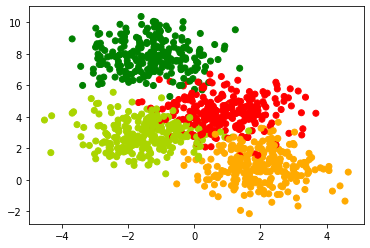

In [0]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [0]:
labels_orig = labels
labels = np.mod(labels_orig,2)

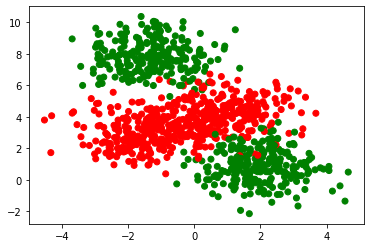

In [0]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape)

(750, 2) (250, 2)


#SN classification

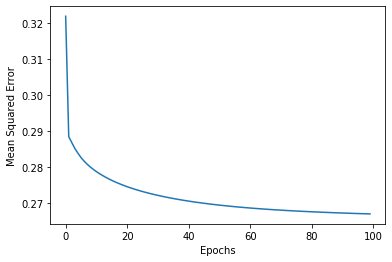

In [0]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=100, learning_rate=0.05, loss_fn='mse', display_loss=True,)

In [0]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = sn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_train,Y_pred_binarised_train)
accuracy_val = accuracy_score(Y_val, Y_pred_binarised_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.73
Validation accuracy 0.72


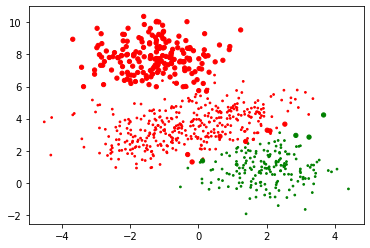

In [0]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()

#Multi class classification

In [0]:
class FFSN_MultiClass:

  def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
 
  def grad_sigmoid(self, x):
    return x*(1-x) 

  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl

  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))

  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False):
      
    if display_loss:
      loss = {}
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
                  
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
        
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
    
    if display_loss:
      plt.plot(np.array(list(loss.values())).astype('float'))
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()
  
  
  

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)

In [0]:
enc = OneHotEncoder()

y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

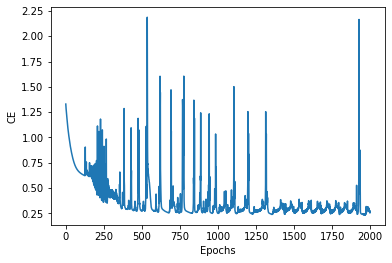

In [0]:
ffsn_multi = FFSN_MultiClass(2,4,[2,3])
ffsn_multi.fit(X_train,y_OH_train,epochs=2000,learning_rate=.005,display_loss=True)

In [0]:
Y_pred_train = ffsn_multi.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = ffsn_multi.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_val = accuracy_score(Y_pred_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.9
Validation accuracy 0.88


#Feed Forward Network

In [0]:
class FFSNNetwork:

  def __init__(self, n_inputs, hidden_sizes=[2]):
    self.nx = n_inputs
    self.ny = 1
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))

  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    return self.H[self.nh+1]

  def grad_sigmoid(self, x):
    return x*(1-x)

  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = self.H[L] - y
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
    
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=False):

    if initialise:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
    if display_loss:
      loss = {}

    for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
        
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * dW[i+1] / m
        self.B[i+1] -= learning_rate * dB[i+1] / m
      
      if display_loss:
        Y_pred = self.predict(X)
        loss[e] = mean_squared_error(Y_pred, Y)
    
    if display_loss:
      plt.plot(np.array(list(loss.values())).astype('float'))
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()


In [0]:
from sklearn.datasets import make_circles

In [0]:
data, labels = make_circles(n_samples=1000, random_state=0, noise=0.05)
print(data.shape, labels.shape)

In [0]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)

In [0]:
ffn = FFSNNetwork(2,[10,10,3,3])

In [0]:

ffn.fit(X_train, Y_train, epochs=100, learning_rate=0.01, display_loss=True)


In [0]:
Y_pred_train = ffn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = ffn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

In [0]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()